## Ego Vehicle

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

sns.set_theme()

FILES = (
    ('stopped_car/stopped_car.csv', 'stopped_car/stopped_car_ego.csv'),
    ('stopped_car_temporal_aligned/stopped_car.csv', 'stopped_car_temporal_aligned/stopped_car_ego.csv'),
    ('both_moving/both_moving.csv', 'both_moving/both_moving_ego.csv'),
    ('both_moving_temporal_aligned/both_moving.csv', 'both_moving_temporal_aligned/both_moving_ego.csv'),
)

EXPERIMENT = FILES[2]


_, ego_file = EXPERIMENT
ego_df = pd.read_csv(
    ego_file,
    names=['timestamp', 'sensor_name', 'n_objects', 'x', 'y', 'vx', 'vy', 'ax', 'ay', 'yaw', 'yaw_rate']
)

ego_df.head()

,timestamp,sensor_name,n_objects,x,y,vx,vy,ax,ay,yaw,yaw_rate
0,1620458101735058071,sensor1,1,-148.99971,-80.00494,0.0,0.0,0.0,0.0,-1.57079,-0.0
1,1620458101736173491,sensor2,1,-148.99971,-80.00494,0.0,0.0,0.0,0.0,-1.57079,-0.0
2,1620458101746698452,sensor1,1,-148.99971,-80.00494,0.0,0.0,0.0,0.0,-1.57079,-0.0
3,1620458101747544672,sensor2,1,-148.99971,-80.00494,0.0,0.0,0.0,0.0,-1.57079,-0.0
4,1620458101762846165,sensor1,1,-148.99971,-80.00494,0.0,0.0,0.0,0.0,-1.57079,-0.0


In [2]:
ego_df['timestamp'] = (ego_df['timestamp'] - ego_df['timestamp'].min()) / 10**9
ego_df1 = ego_df[ego_df.sensor_name == 'sensor1']

ego_df1

,timestamp,sensor_name,n_objects,x,y,vx,vy,ax,ay,yaw,yaw_rate
0,0.000000,sensor1,1,-148.99971,-80.00494,0.00000,0.00000,0.00000,0.00000,-1.57079,-0.00000
2,0.011640,sensor1,1,-148.99971,-80.00494,0.00000,0.00000,0.00000,0.00000,-1.57079,-0.00000
4,0.027788,sensor1,1,-148.99971,-80.00494,0.00000,0.00000,0.00000,0.00000,-1.57079,-0.00000
6,0.043655,sensor1,1,-148.99971,-80.00494,0.00000,0.00000,0.00000,0.00000,-1.57079,-0.00000
8,0.059700,sensor1,1,-148.99971,-80.00494,0.00000,0.00000,0.00000,0.00000,-1.57079,-0.00000
...,...,...,...,...,...,...,...,...,...,...,...
2870,23.047373,sensor1,1,-145.38477,51.99978,-0.19614,5.67965,-0.18479,3.61934,-1.60553,0.00008
2872,23.059671,sensor1,1,-145.38477,51.99978,-0.19614,5.67965,-0.18479,3.61934,-1.60553,0.00008
2874,23.082661,sensor1,1,-145.39265,52.22784,-0.20219,5.82869,-0.15299,3.77274,-1.60552,0.00002
2876,23.091768,sensor1,1,-145.39265,52.22784,-0.20219,5.82869,-0.15299,3.77274,-1.60552,0.00002


In [3]:
obj_file, _ = EXPERIMENT
obj_df = pd.read_csv(
    obj_file,
    names=['timestamp', 'x', 'y', 'vx', 'vy', 'ax', 'ay', 'yaw', 'yaw_rate', 'idx_to_associate', 'association_score', 'association_failed']
)

obj_df.head()

,timestamp,x,y,vx,vy,ax,ay,yaw,yaw_rate,idx_to_associate,association_score,association_failed
0,1620458101735058071,10.00828,1.01118,-0.42131,0.40138,-4.667,4.44619,0.00359,0.0691,0,0.1,1
1,1620458101736173491,10.00828,1.01118,-0.42131,0.40138,-4.667,4.44619,0.00359,0.0691,0,1.0,0
2,1620458101746698452,10.00828,1.01118,-0.42131,0.40138,-4.667,4.44619,0.00359,0.0691,0,1.0,0
3,1620458101747544672,10.00828,1.01118,-0.42131,0.40138,-4.667,4.44619,0.00359,0.0691,0,1.0,0
4,1620458101762846165,10.00828,1.01118,-0.42131,0.40138,-4.667,4.44619,0.00359,0.0691,0,1.0,0


In [4]:
obj_df['timestamp'] = (obj_df['timestamp'] - obj_df['timestamp'].min()) / 10**9
obj_distance = np.hypot(obj_df['x'], obj_df['y'])

errors = obj_df[obj_df.association_failed == 1.0]['timestamp']
errors = errors.iloc[1:]  # The first one is never an error

obj_df['timestamp'].head()

0    0.000000
1    0.001115
2    0.011640
3    0.012487
4    0.027788
Name: timestamp, dtype: float64

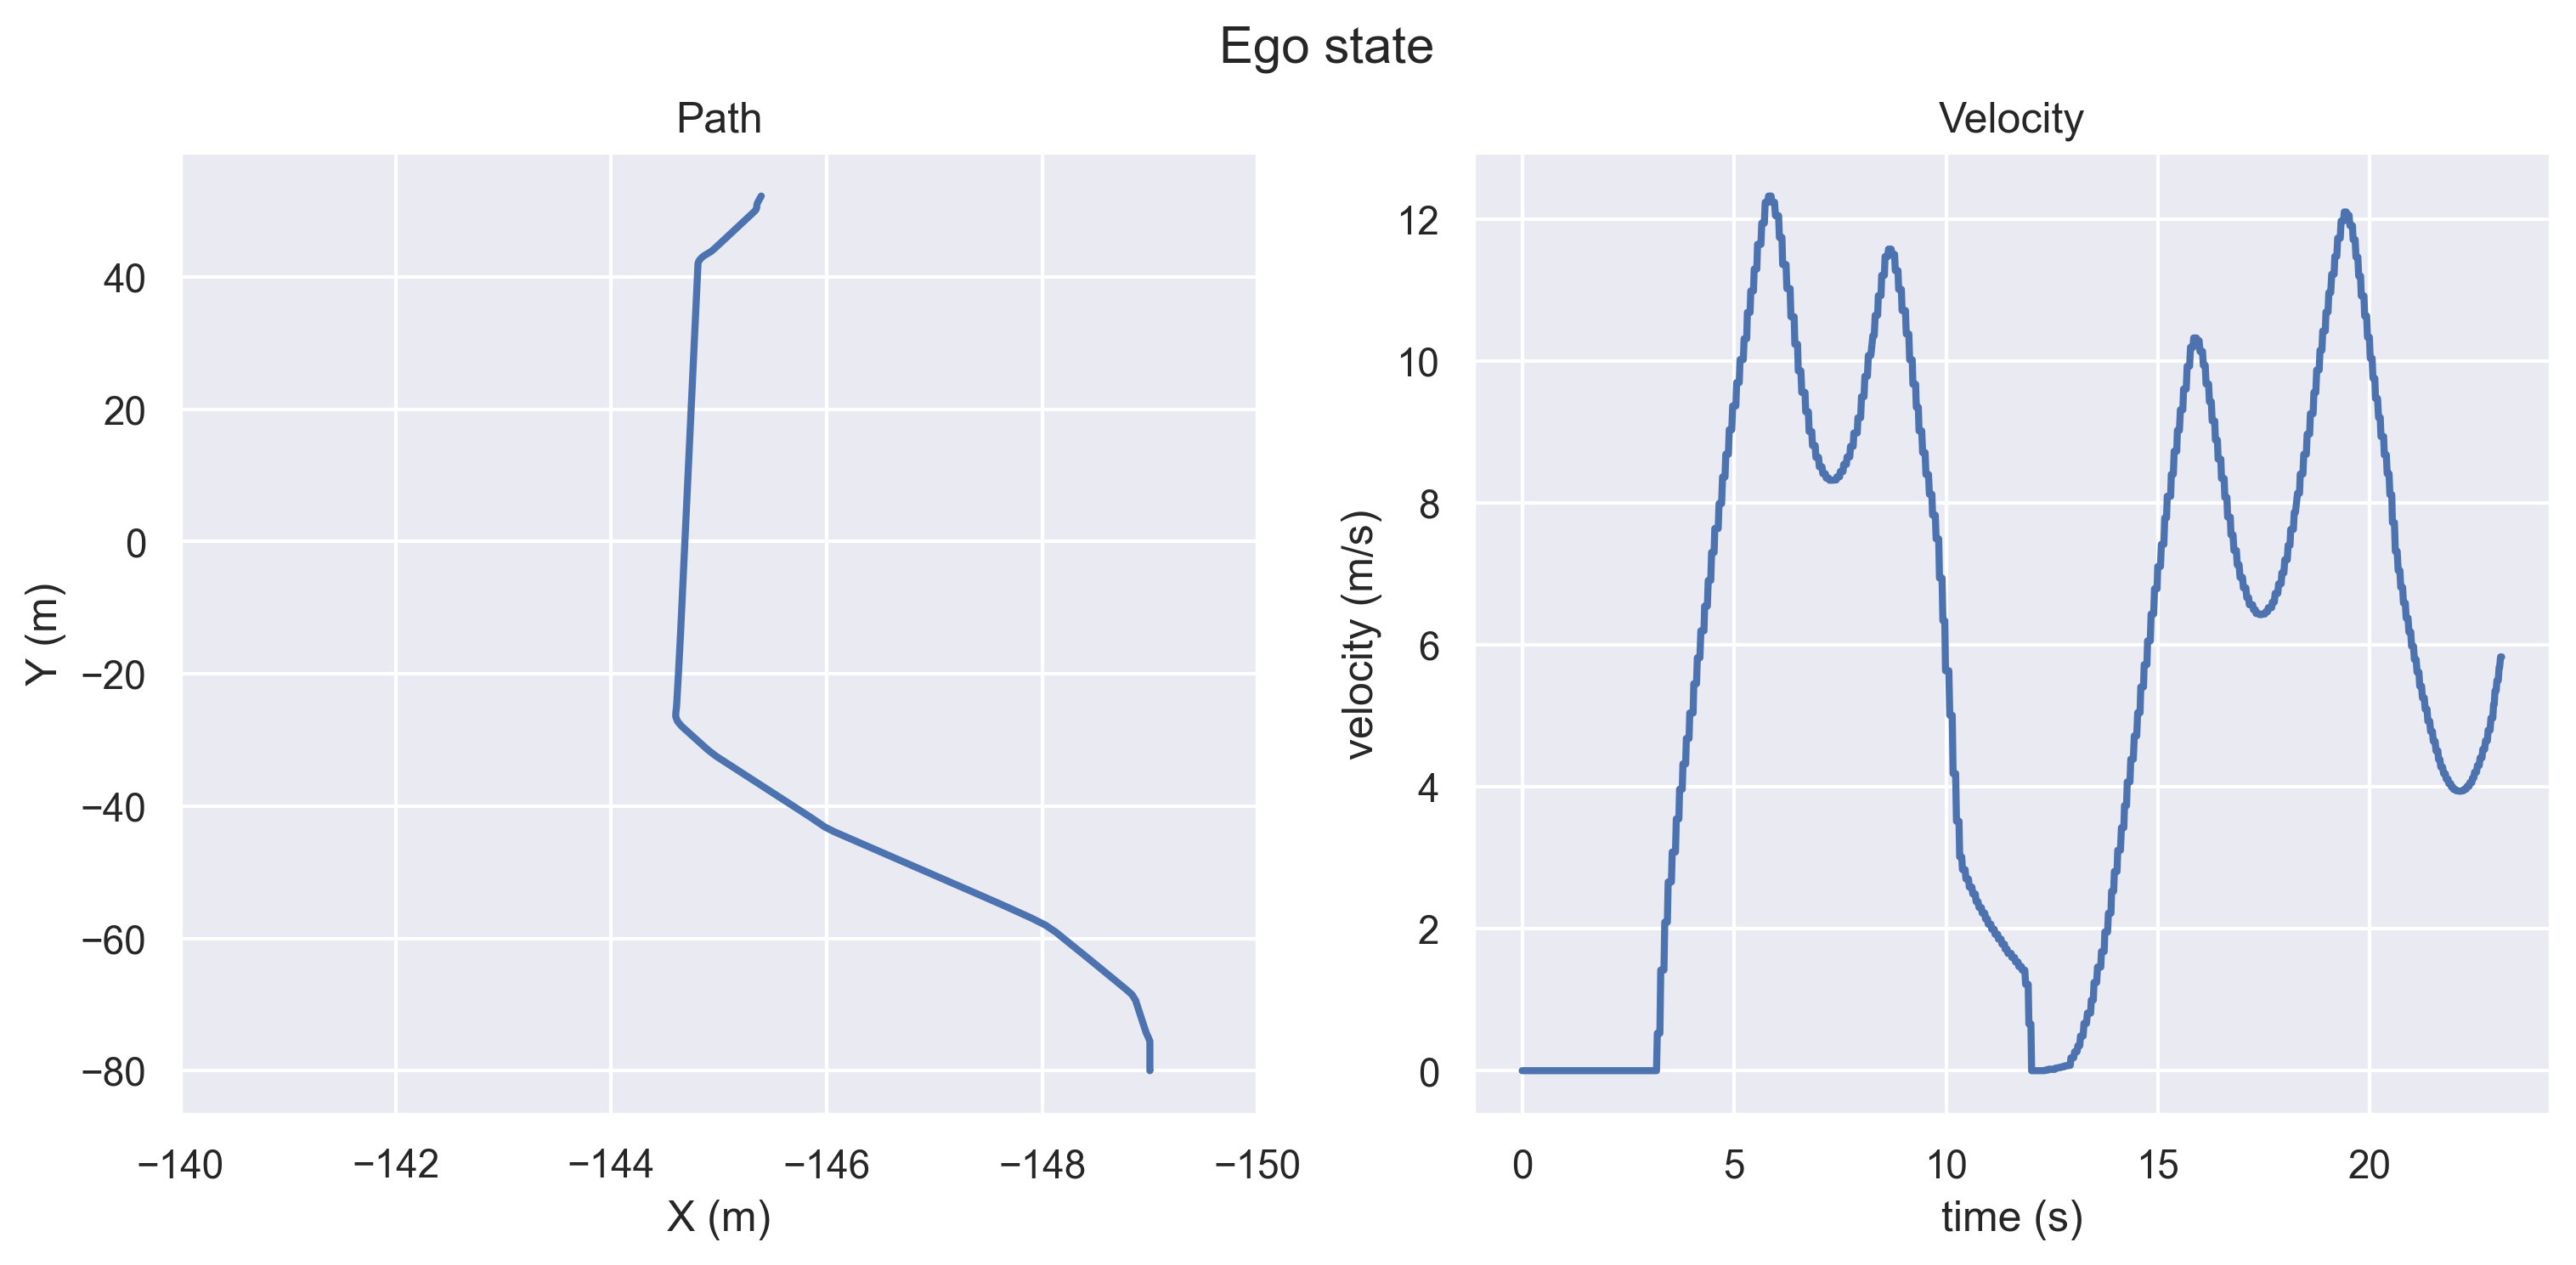

In [5]:
from copy import deepcopy

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 5), dpi=300)

fig.suptitle("Ego state")

axs[0].plot(ego_df1['x'], ego_df1['y'], lw=2)
axs[0].set(
    title='Path',
    xlabel='X (m)',
    ylabel='Y (m)',
    xlim=(-140, -150)
)

ego_speed = np.hypot(ego_df1['vx'], ego_df1['vy'])

axs[1].plot(ego_df1['timestamp'], ego_speed, lw=2)
axs[1].set(
    title='Velocity',
    xlabel='time (s)',
    ylabel='velocity (m/s)',
)

dir_, *_ = obj_file.split('/')
fig.savefig(dir_ + '/ego.png')

In [6]:
# labels = '', 'errors'
# sizes = [obj_df.shape[0], errors.shape[0]]
# explode = (0.0, 0.2)

# fig, ax = plt.subplots(figsize=(6, 6))

# ax.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', shadow=True,
#        textprops={'fontsize': 20, 'color': 'w', 'fontweight': 'bold'})

# fig.suptitle('Association Error Rate') 
# ax.axis('equal')
# ax.legend()

print('Errors', errors.shape[0], obj_df.shape[0])

d = obj_df[obj_df.association_score > 0.1]['association_score']
print(f'Association score (not minimum): {d.mean()} +/- {d.std()}')

Errors 0 2847
Association score (not minimum): 0.9814079409697821 +/- 0.06524746291395504


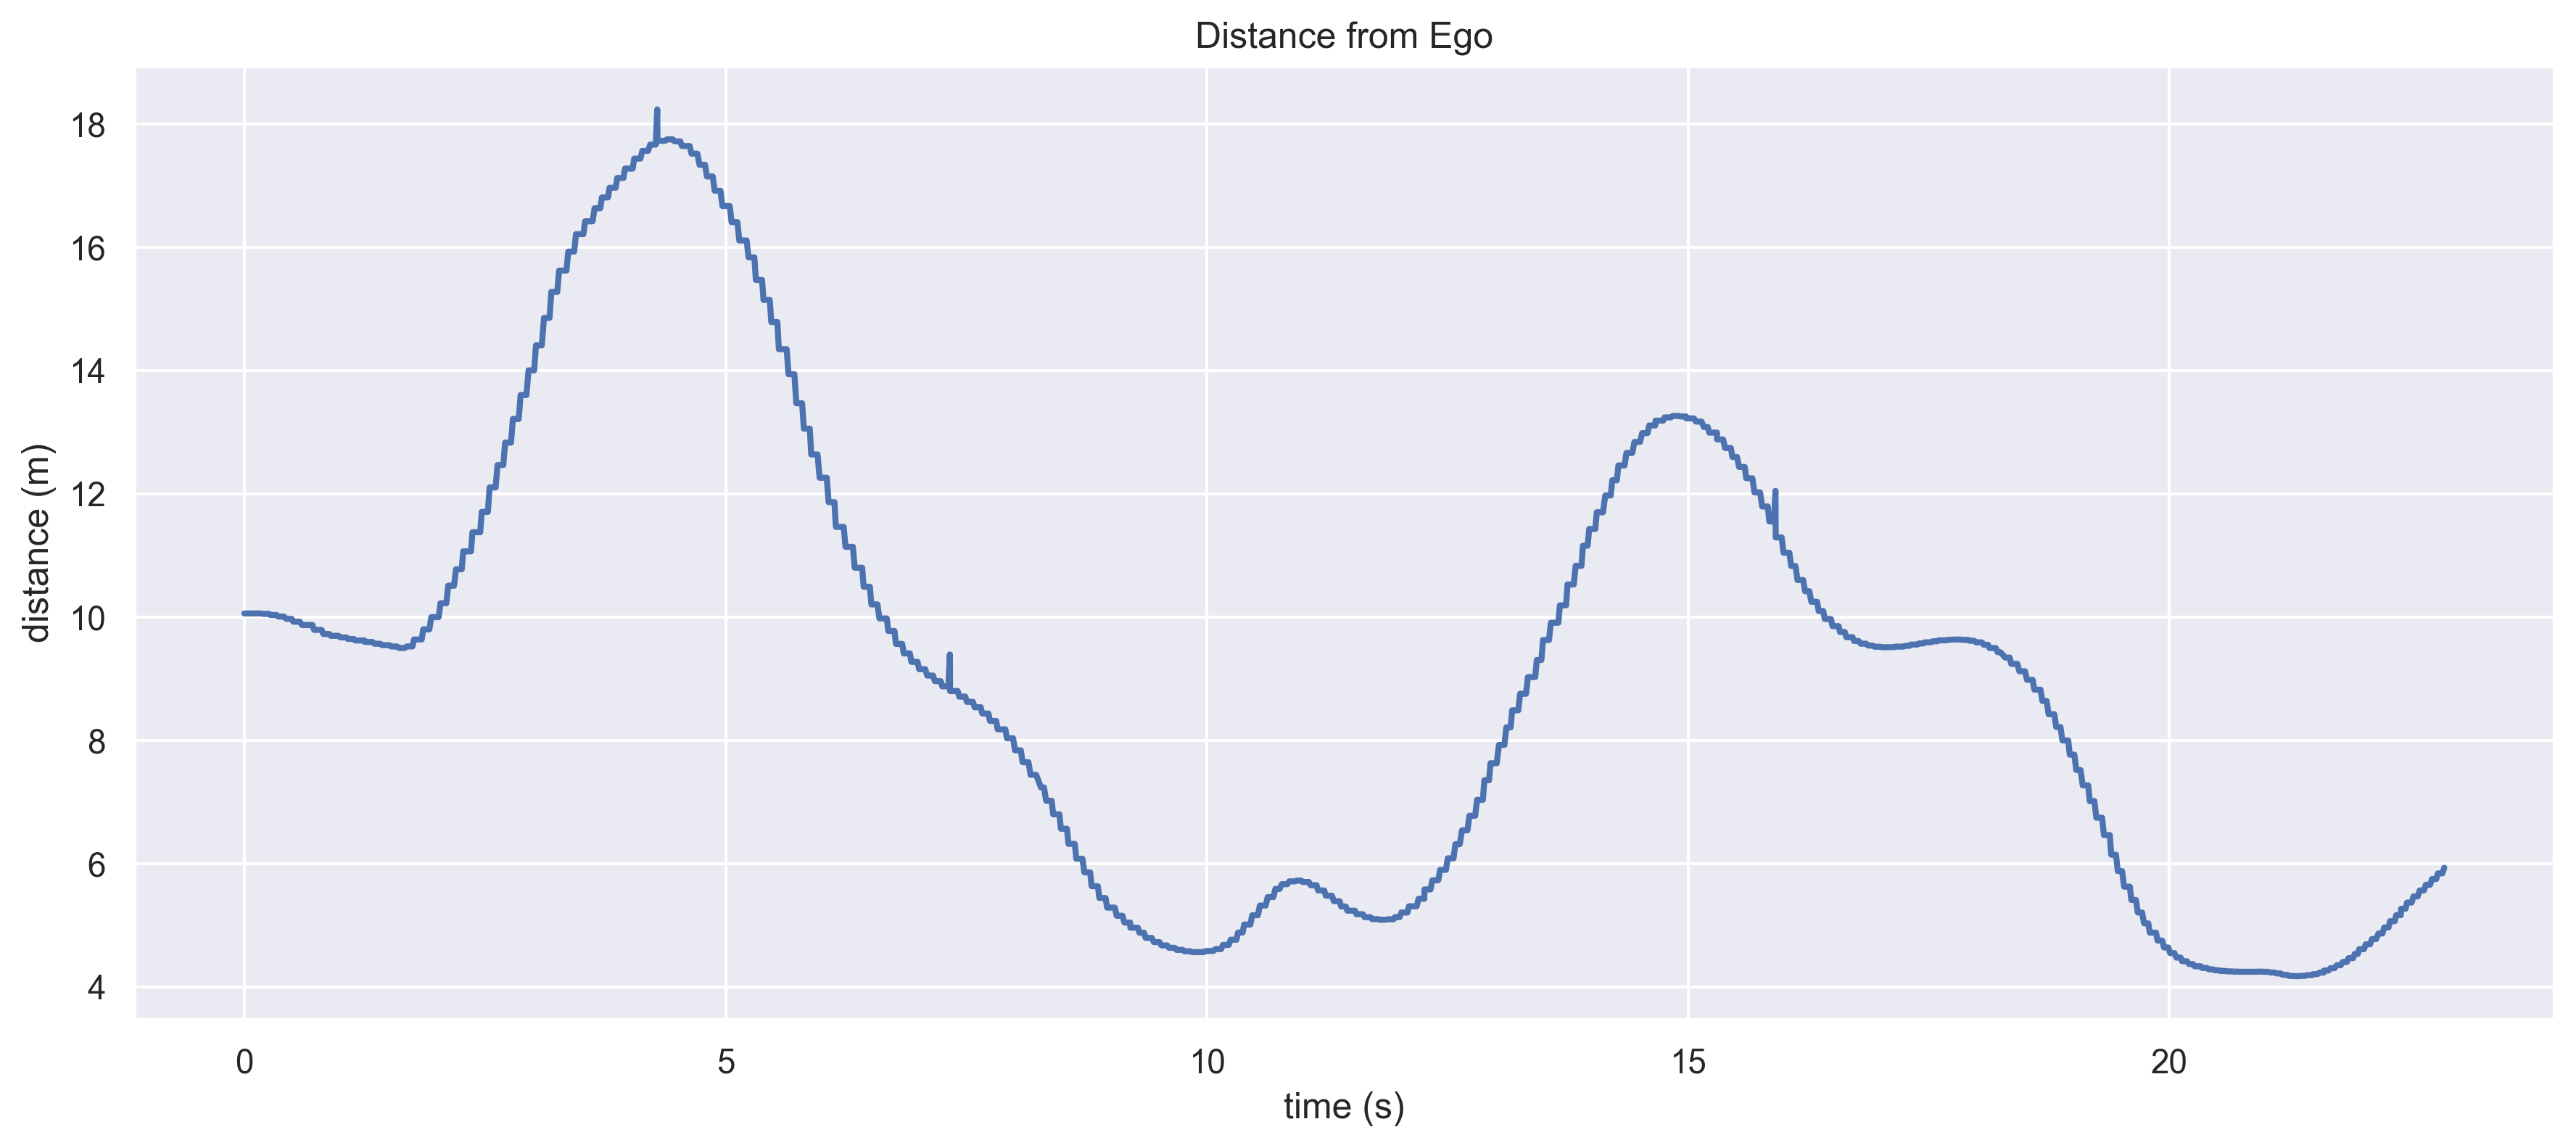

In [7]:
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(12, 10), dpi=300)

axs[0].plot(obj_df['timestamp'], obj_distance, lw=2)
axs[0].set(
    title='Distance from Ego',
    ylabel='distance (m)',
    xlabel='time (s)',
)

if errors.size != 0:
    axs[0].axvline(x=errors.iloc[-1], c='r', lw=0.5, label='association error')
    axs[0].legend()

    axs[1].hist(errors, bins=int(obj_df.shape[0]/errors.shape[0]))
    axs[1].set(
        title='Association Errors',
        ylabel='erros',
        xlabel='time (s)',
    )

    for error in errors:
        axs[0].axvline(x=error, c='r', lw=1)
else:
    fig.delaxes(axs[1])

fig.tight_layout()
fig.savefig(dir_ + '/detected_obj.png')